# 01. Perform simulations

Phase name: 100%|██████████| 337/337 [00:17<00:00, 18.96it/s]


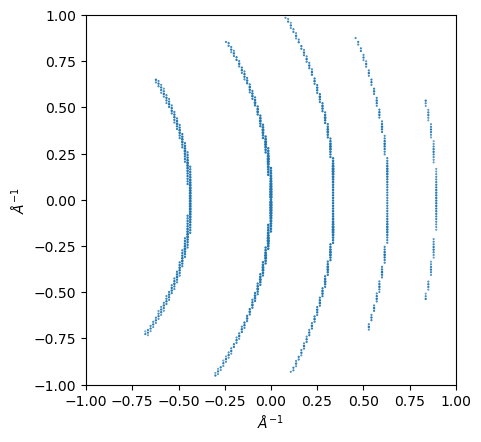

In [ ]:

import simserialED.core as simserialED

simulations = simserialED.simulation.get_simulations_with_params(
    
    a = 80.58, 
    b = 80.9547, 
    c = 80.9547, 
    alpha=71.4081, 
    beta=60.153, 
    gamma=60.153,
    
    spacegroup=2,  # int, not inferred from unit cell
    kv=300,         # kV, acelleration voltage, to determine radius of Ewald's sphere
    angres=10,       # deg, angular resolution of simulations, i.e. the rotation angle in degrees between neighbouring simulations. Lower number = more simulations
)

# Plot the simulations
simulations.plot();

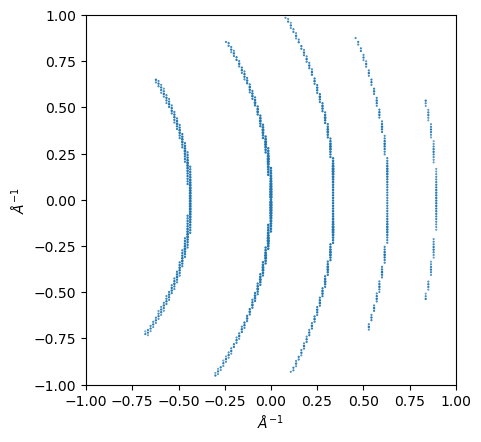

In [2]:

simulations.plot(calibration = 0.0015090274190359715);

In [2]:
# Make sure plots display inline
%matplotlib inline
import os
from tqdm import tqdm
import random
import h5py
import ipywidgets as widgets
from ipywidgets import interact
from helper_functions import copy_h5_file, get_next_simulation_folder, load_h5_data, view_image

# Specify the input HDF5 file
# input_filename = "/Users/xiaodong/Desktop/UOX-simulations/UOX1_sub_radial_backgrounds.h5"
input_filename = "/Users/xiaodong/Desktop/UOX-simulations/empty_backgrounds.h5"
base_dir = os.path.dirname(input_filename)

# 1. Create a new simulation folder
new_sim_folder = get_next_simulation_folder(base_dir)

# 2. Copy the original file to the new simulation folder
output_filename = os.path.join(new_sim_folder, "sim.h5")
copy_h5_file(input_filename, output_filename)

# 3. Process the simulation images.
# Note: 'simulations' should be defined (or imported) before calling process_simulation.

intensity_scale = 1000
with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]
    euler_angles = data["entry"]["data"].require_dataset(
        "simulation_euler_angles", 
        shape=(images.shape[0], 3), 
        dtype=float
    )
    shape = images.shape[-2:]
    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        in_plane = random.uniform(0, 360)
        ind = random.randint(0, simulations.current_size - 1)
        img = simulations.irot[ind].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=(shape[0] // 2, shape[1] // 2),
            sigma=1,
            in_plane_angle=in_plane,
            calibration=0.0015090274190359715,
            fast=True,
            normalize=True,
            fast_clip_threshold=1
        )
        img = (img * intensity_scale).astype(images.dtype)
        images[i] += img
        euler_angles_i = simulations.rotations[ind].to_euler(degrees=True).squeeze()
        euler_angles_i[0] = in_plane  # Override first Euler angle.
        euler_angles[i] = euler_angles_i
print("Processing complete. Updated file saved at:", output_filename)

# 4. Load the processed data for interactive visualization
images_arr, angles_arr = load_h5_data(output_filename)

# 5. Set up the interactive viewer
interact(lambda index: view_image(index, images_arr, angles_arr), 
         index=widgets.IntSlider(min=0, max=images_arr.shape[0]-1, step=1, value=0))


Processing images: 100%|██████████| 500/500 [00:16<00:00, 31.07it/s]


Processing complete. Updated file saved at: /Users/xiaodong/Desktop/UOX-simulations/simulation-59/sim.h5


interactive(children=(IntSlider(value=0, description='index', max=499), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>(index)>